In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
import math
from scipy.special import expit #Vectorized sigmoid function

In [2]:
digitData = "data/ex3data1.mat"
mat = scipy.io.loadmat(digitData)
# X is 5000 x 400 feature matrix where each row reprents an unrolled 20x20 image
X = mat['X']
# y is 5000 x 1 identifier matrix
y = mat['y']

# Insert row of 1's into X
# first param is the target matrix to insert into
# 0 is index 
# 1 is the value to insert
# axis = 1 inserts into rows and axis = 0 inserts into columns
# so now the first column in X is all 1s

# X.shape = (5000,401)
X = np.insert(X, 0, 1,axis = 1)


In [29]:
def reshapeRow(row):
    """
    @param {row} 1 x 401 matrix since an image of a digit is 20x20 + 1 that was added as a bias
    Function that takes in the pixel intensity values and puts it into a 20x20 square 
    """ 
    # the [1:] is used to take everything after the 1st index 
    
    return row[1:].reshape(20,20).T

def displayData(indiciesToDisplay = None):
    """
    Function that selects 100 random examples for the 5000 we have and organizes
    them into a 10x10 matrix
    """
    width = 20
    height = 20
    numRows = 10
    numCols = 10
    
    if not indiciesToDisplay:
        indiciesToDisplay = random.sample(range(X.shape[0]), numRows * numCols)

    
    bigPicture = np.zeros((height * numRows, width * numCols))
    
    iRow = 0
    iCol = 0

    for i in indiciesToDisplay :
        if iCol == numCols:
            iCol = 0
            iRow += 1
 
        curImg = reshapeRow(X[i])
        bigPicture[iRow * height :iRow * height + curImg.shape[0], 
                    iCol * width : iCol * width + curImg.shape[1]] = curImg
        iCol += 1 
    fig = plt.figure( figsize = (6,6) )
    img = scipy.misc.toimage( bigPicture )
    plt.imshow(img,cmap = cm.Greys_r)
    
        
    
    


c:\users\ammar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


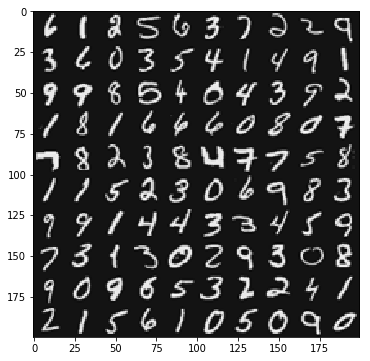

In [30]:
displayData()

In [31]:
def sigmoid(X,theta):
    return expit(np.dot(X,theta))

def costFunction(theta, X, y, lmbda):    
    # theta is passed in as a (num,) need to turn into a np.array (num, 1)
    #theta = theta.reshape(theta.shape[0],1)

    # theta.shape = (401,1)
    # X.shape = (401,5000)
    # y.shape = (5000,1)

    # m = 5000
    m = X.shape[0]
    theta = theta.reshape(theta.shape[0],1)
    t_theta = theta.copy()
    t_theta[0,0] = 0
        
    # hypo.shape = (5000,1) 
    hypo = sigmoid(X, theta)
    
    # temp1.shape = (m,1)
    temp1 =  np.log(hypo)
    # need to use np.multiply instead of np.dot to do elementwise multiplication
    temp1 = np.multiply(temp1,y)
    
    # temp2.shape = (m,1)
    temp2 = np.log(1-hypo)
    temp2 = np.multiply(temp2,(1-y))
    
    # temp 3 = scalar, lmbda/2m is scalar. t_theta**2 is an (n,1) matrix
    temp3 = (lmbda/(2*m)) * np.sum(t_theta**2)
    
    J = (-1/m) * np.sum(temp1+temp2) + temp3

    return J

def gradFunction(theta, X, y, lmbda):
    
    # reshaping theta higher in the hierarchy doesn't seem to carry through functions....
    # theta.shape = (401,1)
    # X.shape = (401,5000)
    # y.shape = (5000,1)
    
    theta = theta.reshape(theta.shape[0],1)
    m = X.shape[0]
    # 400x1
    regterm = theta[1:] * (lmbda/m)
 
    # 5000x1
    temp = sigmoid(X,theta)

    error = temp - y
    
    # 401x1
    grad = (1/m)*np.dot(X.T,error)
    grad[1:] = grad[1:] + regterm
    grad = np.ndarray.flatten(grad)
    return grad


def test():
    #used to test cost and grad func
    tempTheta = np.array( [-2, -1, 1, 2]).reshape(4,1)

    tempX = np.arange(0.1, 1.6, 0.1)
    tempX = tempX.reshape(3,5).T
    tempX = np.insert(tempX, 0, 1,axis = 1)
    tempY = np.array([1,0,1,0,1]).reshape(5,1)

    c = costFunction(tempTheta,tempX,tempY,3)
    # expected value of J = 2.53819
    print("J is %.6f" %(c))
    # expected grad is [ 0.14656137 -0.54855841  0.72472227  1.39800296]
    grad = gradFunction(tempTheta,tempX,tempY,3)
    print(grad)


In [32]:
from scipy import optimize
def optimizeTheta(theta, X, y, lmbda):
    """
    
    """
    rc = optimize.fmin_cg(costFunction, fprime=gradFunction, x0=theta, \
                          args = (X, y, lmbda), maxiter=50, disp=False,\
                          full_output = True)
    return rc[0], rc[1]

In [33]:
def createTheta(numLabels,lmbda):
    """
    Creates an optimized theta for each of the 10 classes
    """
    # tempTheta = 401 x 1
    tempTheta = np.zeros((X.shape[1],1))
    # Theta = 10 x 401
    Theta = np.zeros((numLabels, X.shape[1]))

    for i in range(numLabels):
        print ("Optimizing for handwritten number %d..." % (i))
        if (i == 0):
            curClass = 10
        else:
            curClass = i
        iTheta, minCost = optimizeTheta(tempTheta,X,(y == curClass),lmbda)
        Theta[i,:] = iTheta
        
    print ("Done!")  
    return Theta

In [34]:
def predictOneVsAll(createdTheta,xRow):
    
    # size 10 array populated with 0s, different than np.zeros(10,1)
    hypothesis  = [0]*10
    
    for i in range(10):
        hypothesis[i] = sigmoid(createdTheta[i],xRow)
    
    return np.array(np.argmax(hypothesis))

Optimizing for handwritten number 0...
Optimizing for handwritten number 1...
Optimizing for handwritten number 2...
Optimizing for handwritten number 3...
Optimizing for handwritten number 4...
Optimizing for handwritten number 5...
Optimizing for handwritten number 6...
Optimizing for handwritten number 7...
Optimizing for handwritten number 8...
Optimizing for handwritten number 9...
Done!
Training set accuracy: 85.1%


c:\users\ammar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


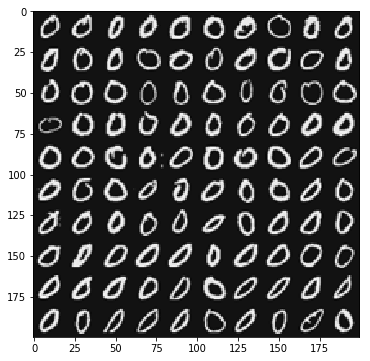

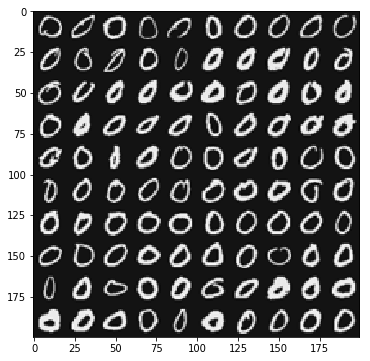

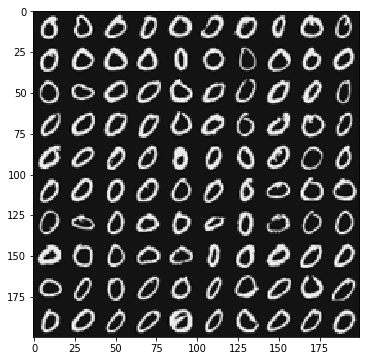

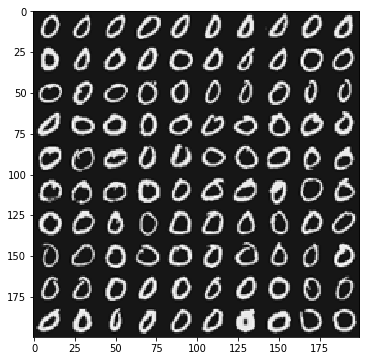

In [35]:

Theta = createTheta(10,0.1)
numCorrect = 0
incorrectIndicies = []

for i in range(X.shape[0]):
    
    if (predictOneVsAll(Theta,X[i]) == y[i]): 
        numCorrect += 1
    else: 
        incorrectIndicies.append(i)
        
print ("Training set accuracy: %0.1f%%" %(100 * (numCorrect / X.shape[0] )))
displayData(incorrectIndicies[:100])
displayData(incorrectIndicies[100:200])
displayData(incorrectIndicies[200:300])
displayData(incorrectIndicies[300:400])

In [ ]:
thetaFile = "data/ex3weights.mat"
weights = scipy.io.loadmat(thetaFile)
# Theta1.shape = (25,401)
Theta1 = mat['Theta1']
# Theta2.shape = (10,26)
Theta2 = mat['Theta2']

In [ ]:
def forwardPropogation(row,Thetas):
    